# Word embeddings and word2vec

In this notebook we will do some work on word embeddings. We will load up the `six_thousand_tweets.csv` file we used in Lecture 5, and we will train a `word2vec` model using `gensim`

## Loading up the packages

We will need `gensim` in version `>4.0.0`, but Colab usually comes with an older version:

In [1]:
!pip freeze | grep gensim

gensim==3.6.0


So we upgrade to a fresher `gensim`:

In [2]:
!pip install --upgrade gensim

     |████████████████████████████████| 23.9 MB 99 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Once this is done, we can implement everything we will need.

In [3]:
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme()

import nltk
nltk.download("wordnet")
nltk.download("stopwords")
from nltk import WordNetLemmatizer

from wordcloud import WordCloud

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, KeyedVectors
from gensim.corpora import Dictionary

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Depending on whether you want to upload the embedding that I give you, or download it directly using `gensim`, you might want to uncomment the next block and run it. It might take up to 10min though.

In [4]:
import gensim.downloader
word_embeddings = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Loading up the data and preprocessing it

In all of the previous lecture we discussed the process of **text normalization**, and we also saw it in practice. I wrote a small function that summarizes the preprocessing, and applies it to the `tweets` dataset. Get familiarized with it and feel free to ask me if anything is not clear :)

In [7]:
tweets = pd.read_csv("six_thousand_tweets.csv")

In [8]:
def clean_text(tweet_text: str) -> str:
  """
  Grabs the text of a tweet and removes
  everything that starts with an ampersand.
  """
  words = tweet_text.split()

  clean_words = [word for word in words if not ("@" in word)]
  return " ".join(clean_words)

In [9]:
def preprocess_tweets(df: pd.DataFrame, remove_stopwords: bool = True) -> List[List[str]]:
  """
  Grabs the 'text' column in df and
  returns a preprocessed list of documents.

  See more in previous class' notebooks.
  """
  preprocessed_docs = df["text"].map(clean_text).values.tolist()
  
  # Doing a simple preprocess using gensim
  preprocessed_docs = [
    simple_preprocess(t, min_len=0, max_len=100) for t in preprocessed_docs
  ]

  # Lemmatizing
  lemmatizer = WordNetLemmatizer()
  preprocessed_docs = [
    [lemmatizer.lemmatize(token) for token in doc] for doc in preprocessed_docs
  ]

  # Removing stopwords
  if remove_stopwords:
    english_stopwords = set(nltk.corpus.stopwords.words("english") + ["http", "wa", "com", "quot", "amp"])
    preprocessed_docs = [
      [word for word in doc if word not in english_stopwords] for doc in preprocessed_docs
    ]

  return preprocessed_docs


After calling `preprocess_tweets` on the dataset we will arrive at a corpus (given by a `List[List[str]]`, the format that `gensim` expects it in).

In [10]:
corpus = preprocess_tweets(tweets)

In [11]:
# Let's remove 1-word sentences, because they lack context.
corpus = [
    doc for doc in corpus if len(doc) > 1
]

In [12]:
corpus[:3]

[['home', 'watching', 'ellen', 'quite', 'long', 'time'],
 ['voted',
  'many',
  'time',
  'bto',
  'tcob',
  'would',
  'gone',
  'nuit',
  'blanche',
  'tcob',
  'oh',
  'well'],
 ['fyi', 'wonderland', 'water', 'infect', 'piercings']]

## Defining a dictionary in `gensim`

One thing that we did not cover in practice was how to create a dictionary (or vocabulary, in the language of the slides) using `gensim`. It's acually quite easy: from `gensim.corpora` we import the `Dictionary` object, and we create an instance by just passing our corpus:

In [15]:
dct = Dictionary(corpus)

You can familiarize yourself with this `dct` object by either using `help`, `?`, using intellisense or reading [its documentation](https://radimrehurek.com/gensim/corpora/dictionary.html). Among the many things you can do, you can access the token at a given index, or you could get the index of a particular token:

In [18]:
# We can access by token id.
print(dct[300])

hand


In [20]:
# we can also get the token from a given id
print(dct.token2id["good"])
print(dct.token2id["bad"])

193
335


In [22]:
# How many unique tokens do we have?
print(len(dct))

8824


## Fitting a word2vec to this corpus

We imported the `Word2Vec` model from `gensim.models`. Defining it and training it is surprisingly easy:

In [32]:
model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)

# We could train it further if we had more samples
model.train(corpus, total_examples=model.corpus_count, epochs=100)

(3910085, 4180300)

We can get the word embeddings by just accessing `model.wv`. `wv` stands for word vectors I believe.

In [28]:
house = model.wv["house"]
house.shape

(100,)

In [29]:
house

array([-0.02871711,  0.09084013,  0.01585079,  0.01902963,  0.02480335,
       -0.16410086,  0.05445227,  0.19187185, -0.07596686, -0.04922431,
       -0.0557416 , -0.15555055, -0.04419393,  0.06394242,  0.02668412,
       -0.06545096,  0.01459231, -0.13057488,  0.00780102, -0.20470574,
        0.05437798,  0.02746976,  0.04799152, -0.0511638 , -0.036114  ,
        0.01595582, -0.06643082, -0.05044428, -0.07901543, -0.01338892,
        0.13336462,  0.005876  ,  0.02261261, -0.07569629, -0.04153407,
        0.1069015 , -0.00165727, -0.09116194, -0.0580098 , -0.18515873,
        0.04068121, -0.07531065, -0.0119041 , -0.00435114,  0.08023848,
       -0.06468939, -0.07375954, -0.00776921,  0.07027966,  0.06746317,
        0.05946441, -0.07347289, -0.04453051, -0.01728389, -0.05518944,
        0.04982126,  0.06096646,  0.00816077, -0.09220409,  0.05470659,
        0.01527367,  0.01800504, -0.0211411 ,  0.00991404, -0.13361792,
        0.09443641,  0.02006367,  0.0496462 , -0.10673114,  0.11

These `wv` object comes with several tools for computing similarity between words.

In [33]:
model.wv.most_similar("good")

[('often', 0.4514877200126648),
 ('lala', 0.43539783358573914),
 ('wailea', 0.42878177762031555),
 ('great', 0.4222360849380493),
 ('political', 0.4199460446834564),
 ('family', 0.4140196740627289),
 ('awful', 0.41253194212913513),
 ('waking', 0.40988731384277344),
 ('misty', 0.405349999666214),
 ('mtn', 0.39282679557800293)]

In [34]:
model.wv.most_similar("bad")

[('emotional', 0.48664793372154236),
 ('wife', 0.4610709547996521),
 ('migraine', 0.4327581226825714),
 ('cause', 0.42482438683509827),
 ('waterproof', 0.42012593150138855),
 ('ajghshgs', 0.4153003990650177),
 ('like', 0.4094255864620209),
 ('fab', 0.40917977690696716),
 ('rubbish', 0.405502587556839),
 ('teeth', 0.39796432852745056)]

Not great, not terrible. For the word embeddings to be useful we usually have to train it in millions of sentences.

## A detour: reducing the dimensionality even further

Why not train an Isomap (or t-SNE, or just PCA) on these word embeddings?

In [ ]:
# Fitting a PCA on the word embeddings, because why not.
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE

X = np.array([
    model.wv[word] for word in dct.values()
])
print(X.shape)

# pca = PCA(n_components=2)
# z_pca = pca.fit_transform(X)

isomap = Isomap(n_components=2, metric="cosine")
z_iso = isomap.fit_transform(X)

# tsne = TSNE(n_components=2)
# z_tsne = tsne.fit_transform(X)

(8824, 100)


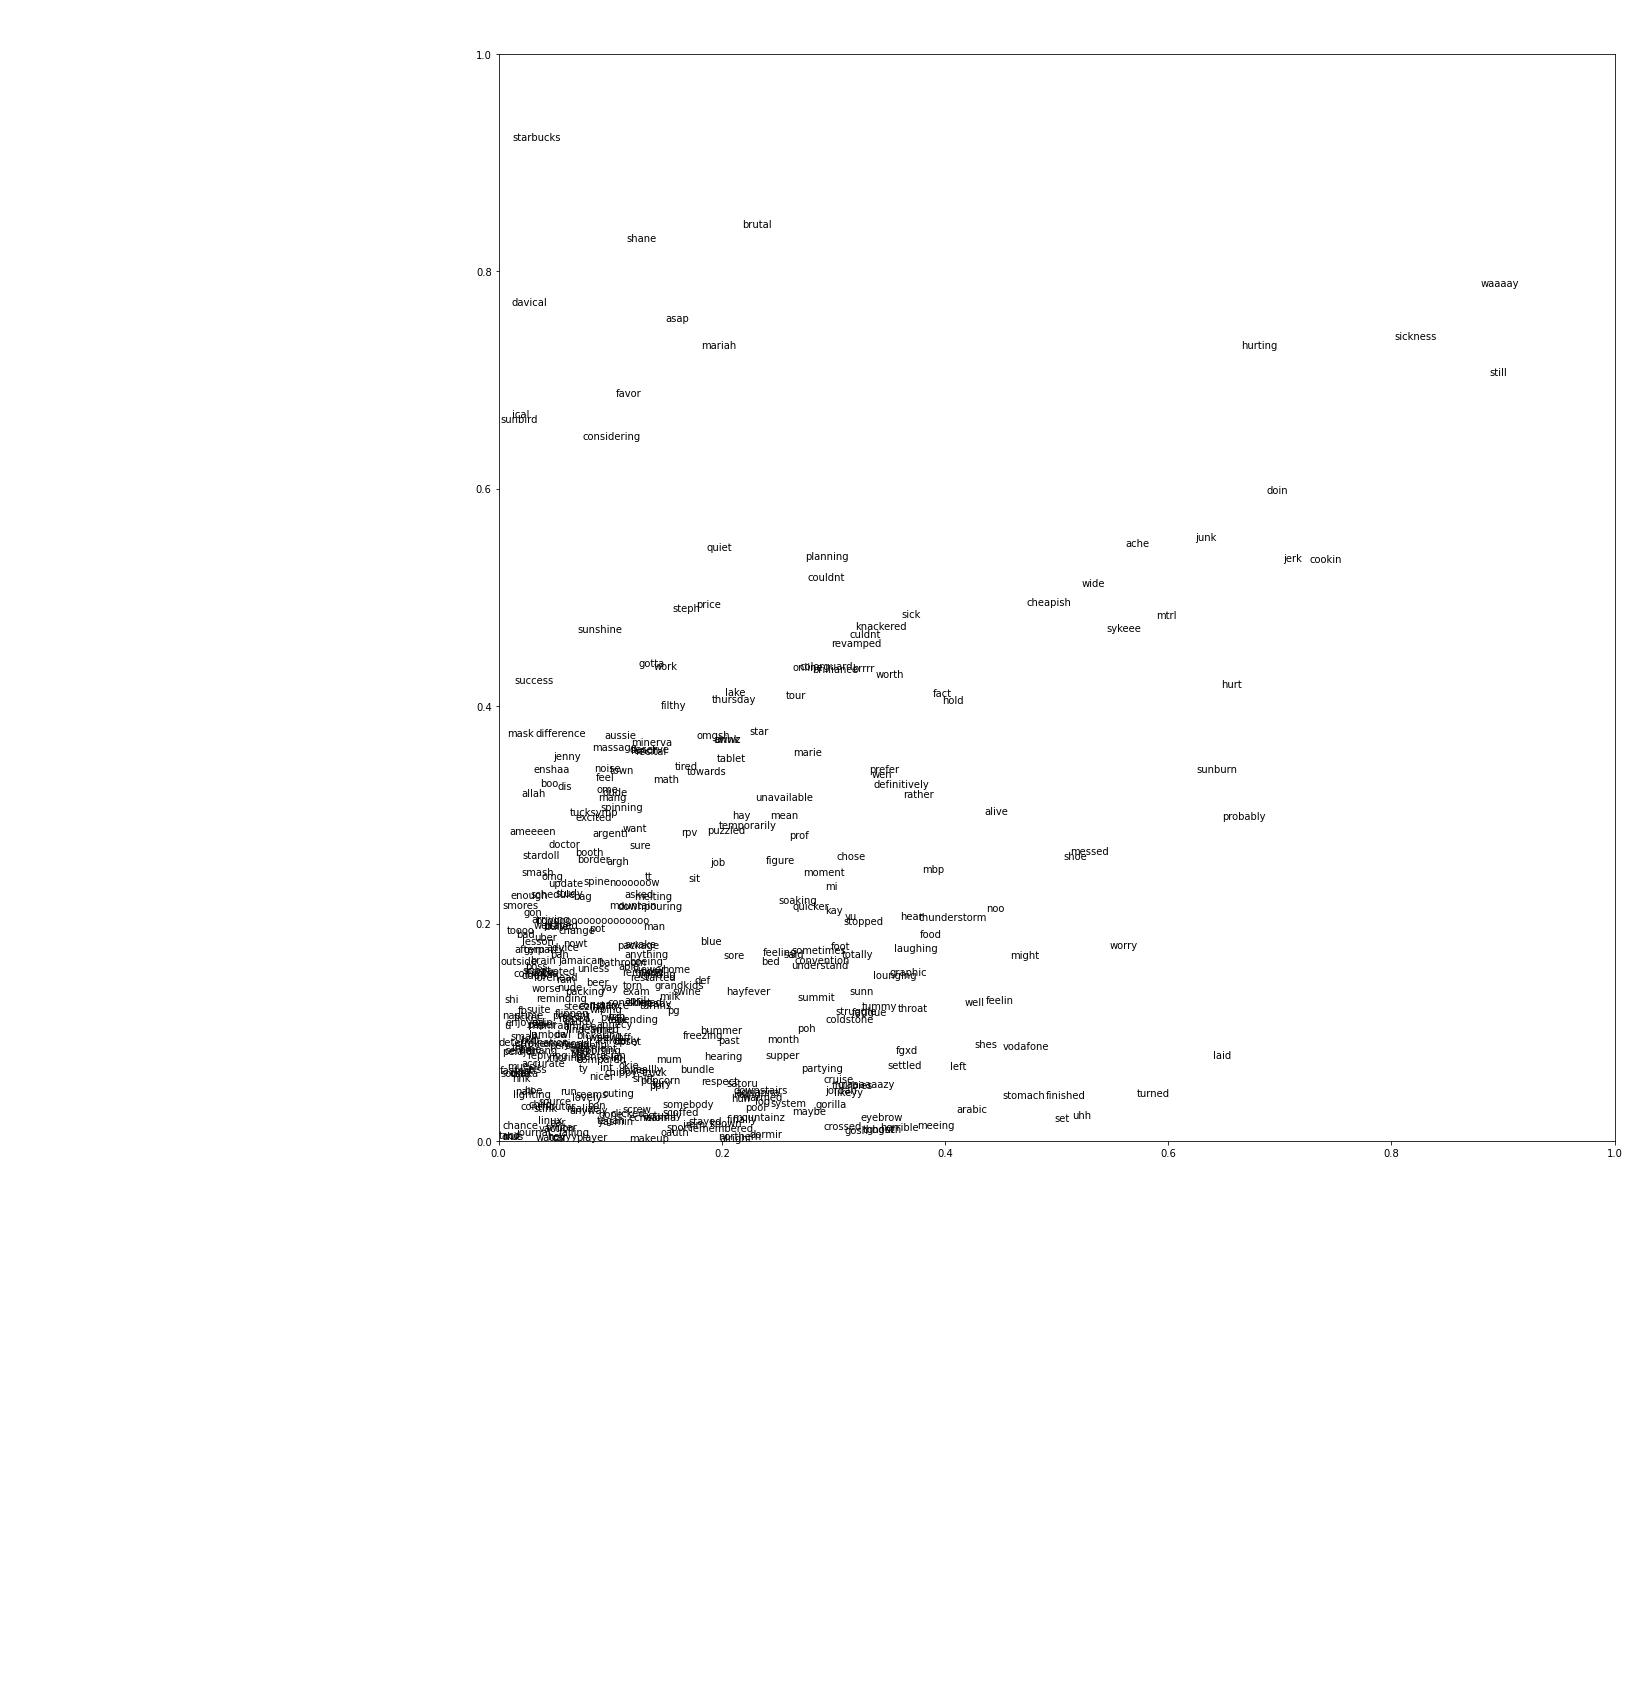

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(20, 20))

for zi, word in zip(z_iso[:3000], dct.values()):
  ax.annotate(word, zi)

# plt.savefig("embeddings_in_2D.png")

I don't really see any structure, unfortunately.

## Saving word embeddings

In [35]:
type(model.wv)

gensim.models.keyedvectors.KeyedVectors

`gensim` implemented these embeddings in a special type called `KeyedVectors`. This object has methods for saving and loading objects. Let's save our `model.wv`:

In [36]:
!ls

sample_data  six_thousand_tweets.csv


In [37]:
model.wv.save("tweets_embeddings.pkl")

In [38]:
!ls

sample_data  six_thousand_tweets.csv  tweets_embeddings.pkl


And we could re-load it using `KeyedVectors.load()`:

In [39]:
tweet_embeddings = KeyedVectors.load("tweets_embeddings.pkl")

## Loading up pre-trained word embeddings

Let's use one of Google's already-trained `word2vec` objects! If you ran one of the cells in the preamble that downloads an object into word_embeddings, good for you. Otherwise, you might want to upload the `google_300.zip` you can find in the Drive and run the following set of cells:

In [40]:
word_embeddings

How big is this word embedding?, how many unique tokens are there?

In [41]:
word_embeddings["house"].shape

(300,)

In [45]:
# word_embeddings["house"]

In [42]:
len(word_embeddings.index_to_key)

3000000

In [46]:
word_embeddings.key_to_index["house"]

541

3 million words... [whistles] That's plenty.

We can get similarity measures for words, and do arithmetic in this latent space:

In [47]:
word_embeddings.most_similar("good")

[('great', 0.7291510105133057),
 ('bad', 0.7190051078796387),
 ('terrific', 0.6889115571975708),
 ('decent', 0.6837348341941833),
 ('nice', 0.6836092472076416),
 ('excellent', 0.644292950630188),
 ('fantastic', 0.6407778263092041),
 ('better', 0.6120728850364685),
 ('solid', 0.5806034803390503),
 ('lousy', 0.576420247554779)]

Why not run e.g. `girl - woman + man`, and check what we get...

In [52]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [48]:
word_embeddings.most_similar(positive=["girl", "man"], negative=["woman"])

[('boy', 0.874837338924408),
 ('teenager', 0.6932152509689331),
 ('teenage_girl', 0.6277070641517639),
 ('lad', 0.6241019368171692),
 ('kid', 0.6167631149291992),
 ('schoolboy', 0.6000924110412598),
 ('teen_ager', 0.5852149724960327),
 ('boys', 0.5807873606681824),
 ('youngster', 0.5773991346359253),
 ('guy', 0.5459756255149841)]

Another example: `paris - france + spain`

In [49]:
word_embeddings.most_similar(positive=["paris", "spain"], negative=["france"])

[('madrid', 0.5295541882514954),
 ('dubai', 0.5092597603797913),
 ('heidi', 0.48901548981666565),
 ('portugal', 0.48763689398765564),
 ('paula', 0.4855714738368988),
 ('alex', 0.4807346761226654),
 ('lohan', 0.4801103174686432),
 ('diego', 0.48010098934173584),
 ('florence', 0.47695302963256836),
 ('costa', 0.4761490523815155)]

This things usually encode our biases in awful ways, for example: `doctor - man + woman` is usually `nurse`. `pilot - man + woman` is usually `flight_attendant`

In [50]:
word_embeddings.most_similar(positive=["doctor", "woman"], negative=["man"])

[('gynecologist', 0.7093892097473145),
 ('nurse', 0.6477287411689758),
 ('doctors', 0.6471460461616516),
 ('physician', 0.6438996195793152),
 ('pediatrician', 0.6249487996101379),
 ('nurse_practitioner', 0.6218312978744507),
 ('obstetrician', 0.6072013974189758),
 ('ob_gyn', 0.5986713171005249),
 ('midwife', 0.5927063226699829),
 ('dermatologist', 0.5739566683769226)]

In [51]:
word_embeddings.most_similar(positive=["pilot", "woman"], negative=["man"])

[('pilots', 0.5367742776870728),
 ('Pilot', 0.5248183012008667),
 ('relaxed_el_Amruni', 0.5235687494277954),
 ('flight_attendant', 0.5034009218215942),
 ('Samoshin', 0.48659560084342957),
 ('piloting', 0.47765547037124634),
 ('Cathy_Bossi', 0.47229763865470886),
 ('Maj._Robert_Grzywna', 0.4710713326931),
 ('Cessna_###R', 0.4550839066505432),
 ('revive_Cabuk', 0.45429396629333496)]